# Fitting Kepler-10 Data

In this workbook we'll go through the process of fitting Kepler data with linear models.

In [64]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

In [65]:
workbook_data = pickle.load(open("data/workbook_1.p", "rb"))
x, y, ye = workbook_data["x"], workbook_data["y"], workbook_data["ye"]
y, ye = y / y.mean(), ye / y.mean()
period, t0, duration = (
    workbook_data["period"],
    workbook_data["t0"],
    workbook_data["duration"],
)

[Text(0.5, 0, 'Time [BKJD]'),
 Text(0, 0.5, 'Flux [e-/s]'),
 Text(0.5, 1.0, 'Kepler-10')]

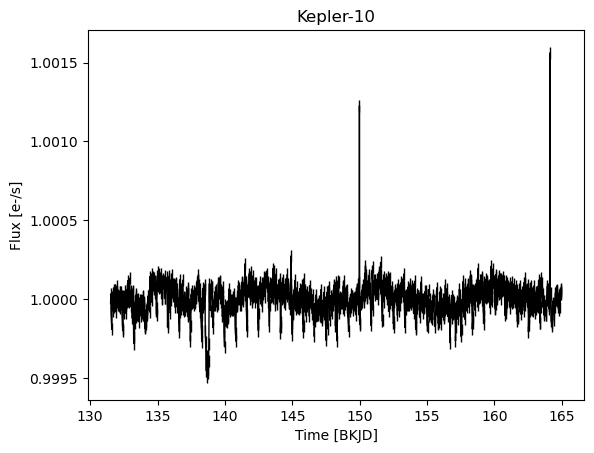

In [66]:
fig, ax = plt.subplots()
ax.errorbar(x, y, ye, color="k", lw=1)
ax.set(xlabel="Time [BKJD]", ylabel="Flux [e-/s]", title="Kepler-10")

## Step 1: Create a design matrix

Create a design matrix for the data above. The design matrix should consist of two "box" transit models (one for each planet) where the model is 0 outside of transit, and -1 during transit. The design matrix should have three vectors, including the first vector which is an offset term.

Overwrite `A` below to be your design matrix.

In [67]:
planets = -np.asarray([((x - t0[idx]) % period[idx] < duration[idx]/2) for idx in range(2)], float).T

A = np.vstack([np.ones_like(x),*planets.T]).T

In [68]:
assert np.isclose(A.dot([1, 0.1, 0.2]).sum(), 1614.5, atol=0.1)

## Step 2: Find the best fitting weights
Use the Weighted Least Squares equation to find the mean best fitting weights. 

Overwrite `w` below to be your mean best fitting weights. 

In [69]:
sigma_w_inv = A.T.dot(A/ye[:,None]**2)
B = A.T.dot(y/ye**2)
w = np.linalg.solve(sigma_w_inv, B)

This is implicitly fitting the transit depth for the planets. Set the transit depth for each planet in `td_1` and `td_2` below.

In [70]:
td_1, td_2 = w[1:]

In [71]:
assert np.isclose(td_1, 0.000143104, rtol=0.1)
assert np.isclose(td_2, 0.00044782345, rtol=0.1)

## Step 3: Improving the model

Assume that the stellar rotation period is `8.235401877719259` days. Create a model for the stellar variability and improve the fit for the transit depths.

Use 

- A sinusoid to capture the stellar variability
- Weighted Least Squares
- A mask to remove outliers

In [72]:
stellar_rotation_period = 8.235401877719259

In [73]:
model = A.dot(w)
outliers = np.abs(y - A.dot(w)) / ye > 20

In [74]:
A = np.vstack(
    [
        [np.sin(2 * i * np.pi * x / stellar_rotation_period),
        np.cos(2 * i * np.pi * x / stellar_rotation_period)]
        for i in range(1,10)
    ]
)
A = np.vstack([A,x**0]).T
A = np.hstack([A, planets])
mask = ~outliers
w = np.linalg.solve(
    A[mask].T.dot(A[mask] / ye[mask][:, None] ** 2),
    A[mask].T.dot(y[mask] / ye[mask] ** 2),
)

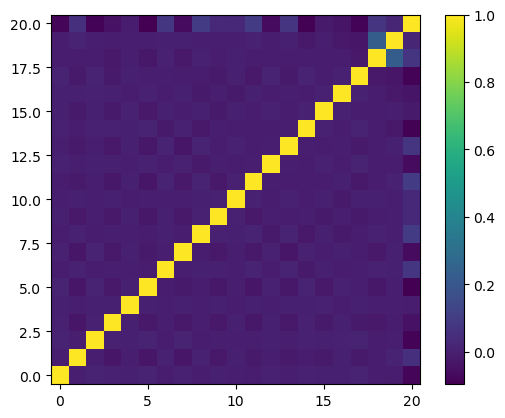

In [75]:
sigma_w_inv = A.T.dot(A/ye[:,None]**2)
w_err = np.linalg.inv(sigma_w_inv)
stddev = np.sqrt(np.diag(w_err))
plt.figure()
plt.imshow(w_err/np.outer(stddev,stddev),origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [76]:
x_new = np.linspace(np.min(x),np.max(x),10000)
planets_new = -np.asarray([((x_new - t0[idx]) % period[idx] < duration[idx]/2) for idx in range(2)], float).T

A_new = np.vstack(
    [
        [np.sin(2 * i * np.pi * x_new / stellar_rotation_period),
        np.cos(2 * i * np.pi * x_new / stellar_rotation_period)]
        for i in range(1,10)
    ]
)
A_new = np.vstack([A_new,x_new**0]).T
A_new = np.hstack([A_new, planets_new])

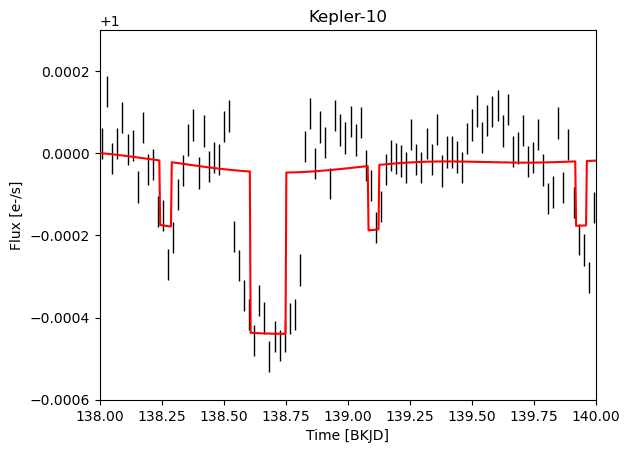

In [77]:
fig, ax = plt.subplots()
ax.errorbar(x, y, ye, color="k", lw=1, label="Data",ls='none')
ax.scatter(x[outliers], y[outliers], color="b", lw=1, label="Data", marker='x')
ax.plot(x_new, A_new.dot(w), c="r", zorder=10, label="Model")
ax.set(xlabel="Time [BKJD]", ylabel="Flux [e-/s]", title="Kepler-10",
       xlim=(138,140),
       ylim=(1-0.6e-3,1+0.3e-3));

In [13]:
assert np.allclose(w[-2:], np.asarray([0.00015893, 0.00040655]), rtol=0.02)